In [24]:
import numpy as np
from scipy import interp
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt
%matplotlib inline
import time
import sqlite3
import itertools
import pandas as pd
from scipy.interpolate import interp1d

## Datas 
Zuwa, I started this part but please can you finc the distribution of those data depending on what we need for the problem + generate random data ?
You might also have to clean the data

In [25]:
DATA_PATH = '/Users/mathildebadoual/code/ecoblock_test/data/database.sqlite'

In [26]:
def import_load_demand(sim_number, sim_id):
    conn = sqlite3.connect(DATA_PATH)
    cur = conn.cursor()
    sql_script = ('SELECT demand FROM results WHERE simulation_id = ? AND simulation_num = ?')
    cur.execute(sql_script, (str(sim_id), str(sim_number)))
    load_demand = cur.fetchall()
    conn.close()
    return np.array(load_demand)

def import_ev_demand(sim_number, sim_id):
    conn = sqlite3.connect(DATA_PATH)
    cur = conn.cursor()
    sql_script = ('SELECT ev_demand FROM results WHERE simulation_id = ? AND simulation_num = ?')
    cur.execute(sql_script, (str(sim_id), str(sim_number)))
    ev_demand = cur.fetchall()
    conn.close()
    return np.array(ev_demand)

def import_pv_generation(sim_number, sim_id):
    conn = sqlite3.connect(DATA_PATH)
    cur = conn.cursor()
    sql_script = ('SELECT pv_generation FROM results WHERE simulation_id = ? AND simulation_num = ?')
    cur.execute(sql_script, (str(sim_id), str(sim_number)))
    pv_generation = cur.fetchall()
    conn.close()
    return np.array(pv_generation)

In [27]:
data = pd.read_csv('price_demand.csv')
data.max()

Year       2015.000
Month        12.000
day          31.000
Hour         24.000
Demand    23169.960
Price       187.891
dtype: float64

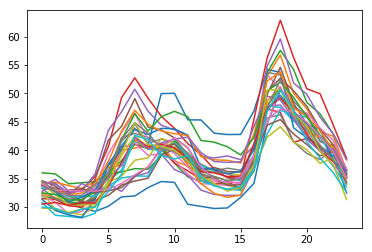

In [28]:
for day in range(1, 31):
    for month in range(1, 2):
        plt.plot(range(0, 24), data[(data['day'] == day) & (data['Month'] == month) & (data['Year'] == 2013)]['Price'])

## Regular Stochastic Control

In [238]:
## SET PARAMETERS
num_station = 3      #This can be changed without changing the code below
ns = 10

N = 24
c = 100
alpha = 0.003
delta_t = 10/N
u_max = 0.4
u_tot_max = 0.03

In [243]:
## GET DATA
prices_day = data[(data['day'] == 1) & (data['Month'] == 1) & (data['Year'] == 2013)]['Price']
prices_interp = interp1d(np.linspace(0, 23, 24), prices_day)
#prices = prices_interp(np.linspace(0, 23, N))
prices = np.flip(prices_interp(np.linspace(0, 23, N)), axis=0)

In [244]:
SOC_shape = tuple([ns for i in range(num_station)])   # This creates a tuple is needed to for any np.reshape operation later

SOC_grid = np.array(list(itertools.product(np.linspace(0, 1, ns), repeat = num_station))) # repeat added...

SOC_tuple = tuple([np.linspace(0,1,ns) for i in range(num_station)])  # This is needed for the interpolation later

In [245]:
u_star = np.zeros((num_station, len(SOC_grid), N))
V = 100000 * np.ones((len(SOC_grid), N+1))

In [246]:
## SOLVE DYNAMIC PROGRAM
start = time.time()

# Boundary Condition of Value Function (Principle of Optimality)

V[-1,N] = 0     #This ensures that the progam only accepts SOC of 1 for all stations at time N.

# Iterate backward in time
for k in range(N-1, 0, -1):

    # Iterate over SOC
    for idx in range(0, len(SOC_grid)):

        # Find dominant bounds for u_batt
        lb = 0
        ub = [min(u_max, (1.0 - SOC_grid[idx, i])/delta_t) for i in range(num_station)]
        
        # Grid Battery Power between dominant bounds
        u_batt_init = np.array(list(itertools.product(np.linspace(lb, u_max, ns), repeat = num_station))) #initializing u_batt
        for i in range(num_station):
            u_batt_init[:,i] = u_batt_init[:,i]*(ub[i]/u_max)  #This ensures that the upperbounds are respected if ub < u_max
        
        u_batt_delete = []            # This list is used to delete u_batt values that break the u_max constraint
        for i in range(len(u_batt_init)):
            if u_batt_init[i].sum() > u_max:
                u_batt_delete.append(i)
            
        u_batt_grid = np.delete(u_batt_init, u_batt_delete, 0)  #This is the real u_batt_grid used in the rest of the code
        #TODO: enlever ceux qui ne respectent pas sum(u_i) <= Umax
        
        # compute next SOC using dynamics
        SOC_nxt = SOC_grid[idx] + delta_t * u_batt_grid
        
        # Cost (no satisfaction)
        g_k = prices[k] * u_batt_grid.sum(axis = 1) 
        
        # Compute value function at nxt time step (need to interpolate)
        V_nxt = 100000*np.ones((len(SOC_nxt),1))
        V_temp = V[:,k+1].reshape(SOC_shape)      #V[k+1] has to be reshaped to work in interpolation
        V_interp_function = RegularGridInterpolator(SOC_tuple, V_temp, method = 'linear')  #n-dimensional interpolation function
        
        V_nxt = V_interp_function(SOC_nxt)

        
        # Value Function (Principle of Optimality)
        V[idx, k] = (delta_t * g_k + V_nxt.T).min()
        ind = np.argmin(delta_t * g_k + V_nxt.T)
        
        # Save Optimal Control
        u_star[:, idx, k] = u_batt_grid[ind]
        
# DP Timer
end = time.time()
print(str(end - start) + " seconds")

73.4031240940094 seconds


In [247]:
## Simulate Results

# Preallocate
SOC_sim = np.zeros((num_station, N))
u_batt_sim = np.zeros((num_station, N))
J_sim = np.zeros((N))

# Initialize
SOC_0 = np.array([0.4, 0.55, 0.2])
SOC_sim[:, 0] = SOC_0

# Simulate PHEV Dynamics
for k in range(0, N-1):
    
    # Use optimal battery power, for given SOC
    for i in range(num_station):
        u_temp_sim = u_star[i,:,k].reshape(SOC_shape)
        u_interp_func= RegularGridInterpolator(SOC_tuple, u_temp_sim, method = 'linear') 
        u_batt_sim[i, k] = u_interp_func(SOC_sim[:,k])      #interpolation necessary for selectign each element of u_batt_sim!
    
    # Energy charging price

    J_sim[k] = prices[k] * np.sum(u_batt_sim[:, k])
    
    # Time-step SOC dynamics
    SOC_sim[:, k+1] = SOC_sim[:, k] + delta_t * u_batt_sim[:, k]

Total cost of charging vehicles =  136.3332628302259 USD


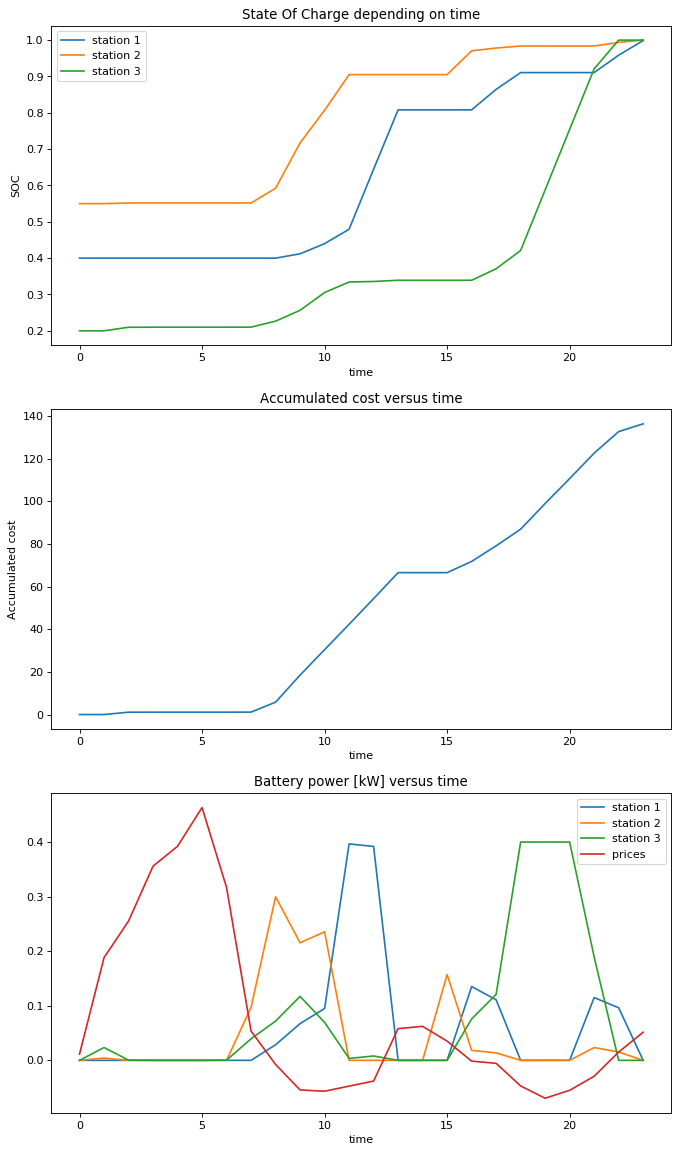

In [248]:
t = np.linspace(0, 23, N)

## Plot Simulation Results
plt.figure(num=3, figsize=(10, 18), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(3,1,1)
plt.plot(t, SOC_sim[0], label='station 1')  
plt.plot(t, SOC_sim[1], label='station 2') 
plt.plot(t, SOC_sim[2], label='station 3')  
plt.title('State Of Charge depending on time')
plt.xlabel('time')
plt.ylabel('SOC')
plt.legend()
# SOC versus time

plt.subplot(3,1,2)
plt.plot(t, [np.sum(J_sim[:k]) for k in range(0, N)])  # plot speed
plt.title('Accumulated cost versus time')
plt.xlabel('time')
plt.ylabel('Accumulated cost')
# Accumulated fuel consumption [g] versus time

plt.subplot(3,1,3)
plt.plot(t, u_batt_sim[0], label='station 1')  
plt.plot(t, u_batt_sim[1], label='station 2') 
plt.plot(t, u_batt_sim[2], label='station 3') 
plt.plot(t, prices/40 - 0.8, label='prices')
plt.title('Battery power [kW] versus time')
plt.xlabel('time')
plt.legend()
# Battery and engine power [kW] versus time

plt.savefig('results.png')
print ("Total cost of charging vehicles = ", J_sim.sum(), "USD")